# Best Practices for Writing Context in a Computer Vision Surveillance App

In [ ]:
!nvidia-smi

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1. Application Context Structure

In [ ]:
"""
Computer Vision Security Guard Application

Purpose:
- Real-time surveillance system for room monitoring and cattle farm security
- Combines YOLO object detection with facial recognition and anomaly detection
- Automated threat detection and notification system

Core Components:
1. Facial Recognition for authorized personnel
2. Object detection and tracking using YOLO
3. Pose estimation and anomaly detection
4. Alert system with email notifications
5. Cattle monitoring and theft prevention
"""

class SecurityGuardContext:
    def __init__(self):
        self.app_name = "VisionGuard Security System"
        self.version = "1.0"
        self.purpose = "Automated surveillance and threat detection"
        
    def initialize_context(self):
        return {
            "system_mode": "active_surveillance",
            "detection_models": {
                "object_detection": "YOLOv8",
                "facial_recognition": "FaceNet/ArcFace",
                "pose_estimation": "OpenPose/MoveNet",
                "anomaly_detection": "Autoencoder/Isolation Forest"
            },
            "monitoring_scopes": [
                "unauthorized_person_detection",
                "cattle_movement_monitoring",
                "suspicious_activity_detection",
                "theft_prevention"
            ]
        }

2. Configuration Context Management

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional
from pathlib import Path

@dataclass
class AppConfig:
    """Central configuration context for the surveillance app"""
    # Path configurations
    # family_members_dir: Path = Path("data/family_members")
    family_members_dir: Path = Path("family_members")
    models_dir: Path = Path("models")
    logs_dir: Path = Path("logs")
    
    # Model configurations
    confidence_threshold: float = 0.7
    facial_recognition_threshold: float = 0.8
    frame_skip: int = 5  # Process every 5th frame for efficiency
    
    # Alert configurations
    email_notifications: bool = True
    alert_cooldown: int = 300  # 5 minutes between repeated alerts
    
    # Camera configurations
    camera_source: str = "0"  # "0" for webcam, or RTSP URL
    frame_width: int = 1280
    frame_height: int = 720

class SecurityContext:
    def __init__(self, config: AppConfig):
        self.config = config
        self.authorized_persons = self._load_authorized_persons()
        self.detection_history = {}
        self.alert_status = {}
        
    def _load_authorized_persons(self) -> Dict[str, List]:
        """Load and validate authorized persons from directory structure"""
        authorized = {}
        if self.config.family_members_dir.exists():
            for person_dir in self.config.family_members_dir.iterdir():
                if person_dir.is_dir():
                    person_name = person_dir.name
                    images = list(person_dir.glob("*.jpg")) + list(person_dir.glob("*.png"))
                    if images:
                        authorized[person_name] = images
        return authorized

3. Real-time Detection Context

In [ ]:
class DetectionContext:
    """Manages real-time detection and tracking context"""
    
    def __init__(self):
        self.active_detections = {}
        self.tracked_objects = {}
        self.suspicious_activities = []
        self.frame_count = 0
        
    def update_detection_context(self, detections: List, frame_timestamp: float):
        """Update context with new detections"""
        context_update = {
            "timestamp": frame_timestamp,
            "total_detections": len(detections),
            "unauthorized_count": 0,
            "cattle_count": 0,
            "suspicious_movements": []
        }
        
        for detection in detections:
            self._process_detection(detection, context_update)
            
        return context_update
    
    def _process_detection(self, detection: Dict, context: Dict):
        """Process individual detection and update context"""
        if detection['class'] == 'person':
            if not self._is_authorized_person(detection):
                context['unauthorized_count'] += 1
                self._evaluate_suspicious_behavior(detection, context)
        elif detection['class'] == 'cattle':
            context['cattle_count'] += 1
            self._monitor_cattle_behavior(detection)

4. Facial Recognition Context

In [ ]:
class FacialRecognitionContext:
    """Manages facial recognition context and authorization"""
    
    def __init__(self, known_faces_dir: Path):
        self.known_faces = self._load_known_faces(known_faces_dir)
        self.recognition_threshold = 0.8
        self.recognition_history = {}
        
    def _load_known_faces(self, known_faces_dir: Path) -> Dict[str, List]:
        """Load known faces with proper error handling and validation"""
        known_faces = {}
        
        try:
            if not known_faces_dir.exists():
                raise FileNotFoundError(f"Directory {known_faces_dir} not found")
                
            for person_dir in known_faces_dir.iterdir():
                if person_dir.is_dir():
                    person_name = person_dir.name
                    face_encodings = []
                    
                    for image_path in person_dir.glob("*.*"):
                        if image_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                            encoding = self._encode_face(image_path)
                            if encoding is not None:
                                face_encodings.append(encoding)
                    
                    if face_encodings:
                        known_faces[person_name] = face_encodings
                        
        except Exception as e:
            print(f"Error loading known faces: {e}")
            
        return known_faces
    
    def verify_person(self, face_encoding, current_frame) -> Dict:
        """Verify if detected person is authorized"""
        verification_context = {
            "authorized": False,
            "identity": "unknown",
            "confidence": 0.0,
            "first_detected": current_frame.timestamp,
            "detection_count": 0
        }
        
        best_match = None
        best_confidence = 0.0
        
        for name, encodings in self.known_faces.items():
            for known_encoding in encodings:
                confidence = self._compare_faces(face_encoding, known_encoding)
                if confidence > best_confidence:
                    best_confidence = confidence
                    best_match = name
        
        if best_match and best_confidence >= self.recognition_threshold:
            verification_context.update({
                "authorized": True,
                "identity": best_match,
                "confidence": best_confidence
            })
            
        return verification_context

5. Alert and Notification Context

In [ ]:
class AlertContext:
    """Manages alert generation and notification context"""
    
    def __init__(self, config: AppConfig):
        self.config = config
        self.alert_cooldowns = {}
        self.alert_categories = {
            "unauthorized_person": {
                "priority": "high",
                "message": "Unauthorized person detected",
                "cooldown": 300  # 5 minutes
            },
            "suspicious_activity": {
                "priority": "medium", 
                "message": "Suspicious activity detected",
                "cooldown": 180  # 3 minutes
            },
            "cattle_theft_attempt": {
                "priority": "critical",
                "message": "Possible cattle theft attempt",
                "cooldown": 60  # 1 minute
            }
        }
    
    def should_trigger_alert(self, alert_type: str, detection_context: Dict) -> bool:
        """Determine if alert should be triggered based on context"""
        current_time = time.time()
        
        # Check cooldown period
        if alert_type in self.alert_cooldowns:
            if current_time - self.alert_cooldowns[alert_type] < self.alert_categories[alert_type]["cooldown"]:
                return False
        
        # Context-based alert validation
        if alert_type == "unauthorized_person":
            return self._validate_unauthorized_alert(detection_context)
        elif alert_type == "suspicious_activity":
            return self._validate_suspicious_alert(detection_context)
            
        return True
    
    def _validate_unauthorized_alert(self, context: Dict) -> bool:
        """Validate unauthorized person alert context"""
        return (context['unauthorized_count'] > 0 and 
                context.get('tracking_duration', 0) > 10)  # Tracked for 10+ frames

6. Main Application Context Integration

In [ ]:
class SecurityGuardApp:
    """Main application context integrating all components"""
    
    def __init__(self):
        self.config = AppConfig()
        self.security_context = SecurityContext(self.config)
        self.detection_context = DetectionContext()
        self.facial_context = FacialRecognitionContext(self.config.family_members_dir)
        self.alert_context = AlertContext(self.config)
        
        # Initialize models
        self.yolo_model = self._initialize_yolo()
        self.pose_model = self._initialize_pose_estimation()
        
    def process_frame(self, frame):
        """Main processing pipeline with comprehensive context"""
        frame_context = {
            "timestamp": time.time(),
            "frame_shape": frame.shape,
            "detections": [],
            "alerts_triggered": []
        }
        
        # Object detection
        detections = self.yolo_model.detect(frame)
        frame_context["detections"] = detections
        
        # Update detection context
        detection_update = self.detection_context.update_detection_context(
            detections, frame_context["timestamp"]
        )
        frame_context.update(detection_update)
        
        # Facial recognition for detected persons
        persons = [d for d in detections if d['class'] == 'person']
        for person in persons:
            facial_result = self.facial_context.verify_person(
                person['face_encoding'], frame_context
            )
            person.update(facial_result)
            
            # Check for alerts
            if not facial_result['authorized']:
                alert_data = self.alert_context.evaluate_alert(
                    "unauthorized_person", person, frame_context
                )
                if alert_data:
                    frame_context["alerts_triggered"].append(alert_data)
        
        return frame_context

Extended Security Surveillance System with Ultralytics SecurityAlarm

# extended_security_alarm.py

1. Extended SecurityAlarm Class

In [ ]:
# extended_security_alarm.py

import cv2
import numpy as np
from pathlib import Path
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from datetime import datetime, timedelta
import logging
from typing import Dict, List, Optional, Tuple

from ultralytics import YOLO, solutions
from ultralytics.solutions.solutions import BaseSolution, SolutionAnnotator, SolutionResults
from ultralytics.utils import LOGGER
from ultralytics.utils.plotting import colors


class ExtendedSecurityAlarm(solutions.SecurityAlarm):
    """
    Extended Security Alarm System with facial recognition, cattle monitoring, and enhanced features.
    
    This class extends the Ultralytics SecurityAlarm with:
    - Facial recognition for authorized personnel
    - Cattle monitoring and theft prevention
    - Multiple input source support (webcam, video, image)
    - Enhanced alert system with cooldown periods
    - Pose estimation and anomaly detection
    - Customizable detection zones
    """

    def __init__(self, **kwargs):
        """
        Initialize extended security alarm system.
        
        Args:
            **kwargs: Additional arguments including:
                family_members_dir (str): Directory containing authorized person images
                facial_recognition_threshold (float): Threshold for face recognition
                cattle_monitoring (bool): Enable cattle monitoring
                alert_cooldown (int): Cooldown period between alerts in seconds
                min_cattle_count (int): Minimum cattle count for theft detection
        """
        super().__init__(**kwargs)
        
        # Extended configuration
        self.family_members_dir = Path(kwargs.get("family_members_dir", "data/family_members"))
        self.facial_recognition_threshold = kwargs.get("facial_recognition_threshold", 0.8)
        self.cattle_monitoring = kwargs.get("cattle_monitoring", True)
        self.alert_cooldown = kwargs.get("alert_cooldown", 300)  # 5 minutes
        self.min_cattle_count = kwargs.get("min_cattle_count", 1)
        
        # Extended state
        self.known_faces = {}
        self.face_encodings = {}
        self.authorized_track_ids = set()
        self.cattle_count_history = []
        self.last_alert_time = {}
        self.unauthorized_detections = []
        
        # Initialize extended features
        self._setup_extended_features()
    
    def _setup_extended_features(self):
        """Setup extended features like face recognition"""
        self.load_known_faces()
        self.setup_logging()
    
    def setup_logging(self):
        """Setup extended logging"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler('extended_security.log'),
                logging.StreamHandler()
            ]
        )
    
    def load_known_faces(self):
        """Load known faces from family_members directory"""
        LOGGER.info("Loading known faces...")
        
        if not self.family_members_dir.exists():
            LOGGER.warning(f"Family members directory {self.family_members_dir} not found")
            return
        
        for person_dir in self.family_members_dir.iterdir():
            if person_dir.is_dir():
                person_name = person_dir.name
                self.known_faces[person_name] = []
                self.face_encodings[person_name] = []
                
                for img_path in person_dir.glob("*.*"):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        try:
                            image = cv2.imread(str(img_path))
                            if image is not None:
                                encoding = self.extract_face_encoding(image)
                                if encoding is not None:
                                    self.known_faces[person_name].append(img_path)
                                    self.face_encodings[person_name].append(encoding)
                                    LOGGER.info(f"Loaded face for {person_name}: {img_path.name}")
                        except Exception as e:
                            LOGGER.error(f"Error loading {img_path}: {e}")
    
    def extract_face_encoding(self, image: np.ndarray) -> Optional[np.ndarray]:
        """
        Extract face encoding from image.
        
        Args:
            image: Input image containing face
            
        Returns:
            Face encoding vector or None if no face detected
        """
        try:
            # Convert to RGB
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Simple face encoding (replace with more sophisticated method)
            encoding = self._simple_face_encoding(rgb_image)
            return encoding
        except Exception as e:
            LOGGER.error(f"Error extracting face encoding: {e}")
            return None
    
    def _simple_face_encoding(self, image: np.ndarray) -> np.ndarray:
        """
        Simple face encoding method.
        In production, replace with proper face recognition model.
        
        Args:
            image: RGB image
            
        Returns:
            Face encoding vector
        """
        # Resize to standard size
        resized = cv2.resize(image, (128, 128))
        # Convert to grayscale
        gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
        # Apply histogram equalization
        equalized = cv2.equalizeHist(gray)
        # Flatten and normalize
        encoding = equalized.flatten() / 255.0
        return encoding
    
    def recognize_face(self, face_image: np.ndarray) -> Tuple[str, float]:
        """
        Recognize face from detected face image.
        
        Args:
            face_image: Cropped face image
            
        Returns:
            Tuple of (identity, confidence)
        """
        try:
            encoding = self.extract_face_encoding(face_image)
            if encoding is None:
                return "Unknown", 0.0
            
            best_match = None
            best_similarity = 0.0
            
            for person_name, encodings in self.face_encodings.items():
                for known_encoding in encodings:
                    similarity = self._calculate_similarity(encoding, known_encoding)
                    if similarity > best_similarity:
                        best_similarity = similarity
                        best_match = person_name
            
            if best_similarity >= self.facial_recognition_threshold:
                return best_match, best_similarity
            else:
                return "Unknown", best_similarity
                
        except Exception as e:
            LOGGER.error(f"Error in face recognition: {e}")
            return "Unknown", 0.0
    
    def _calculate_similarity(self, encoding1: np.ndarray, encoding2: np.ndarray) -> float:
        """
        Calculate cosine similarity between two encodings.
        
        Args:
            encoding1: First encoding vector
            encoding2: Second encoding vector
            
        Returns:
            Similarity score between 0 and 1
        """
        dot_product = np.dot(encoding1, encoding2)
        norm1 = np.linalg.norm(encoding1)
        norm2 = np.linalg.norm(encoding2)
        
        if norm1 == 0 or norm2 == 0:
            return 0.0
            
        return dot_product / (norm1 * norm2)
    
    def should_send_alert(self, alert_type: str) -> bool:
        """
        Check if alert should be sent based on cooldown period.
        
        Args:
            alert_type: Type of alert
            
        Returns:
            True if alert should be sent
        """
        current_time = datetime.now()
        
        if alert_type in self.last_alert_time:
            time_diff = (current_time - self.last_alert_time[alert_type]).total_seconds()
            if time_diff < self.alert_cooldown:
                return False
        
        self.last_alert_time[alert_type] = current_time
        return True
    
    def send_extended_email(self, im0: np.ndarray, alert_type: str, details: Dict):
        """
        Send extended email alert with detailed information.
        
        Args:
            im0: Image frame
            alert_type: Type of alert
            details: Additional alert details
        """
        if not self.server:
            LOGGER.warning("Email server not authenticated")
            return
        
        try:
            # Encode image
            img_bytes = cv2.imencode(".jpg", im0)[1].tobytes()
            
            # Create message
            message = MIMEMultipart()
            message["From"] = self.from_email
            message["To"] = self.to_email
            
            # Customize subject based on alert type
            if alert_type == "unauthorized_person":
                message["Subject"] = "SECURITY ALERT: Unauthorized Person Detected"
                body = self._create_unauthorized_person_body(details)
            elif alert_type == "cattle_theft":
                message["Subject"] = "CRITICAL ALERT: Possible Cattle Theft"
                body = self._create_cattle_theft_body(details)
            elif alert_type == "suspicious_activity":
                message["Subject"] = "ALERT: Suspicious Activity Detected"
                body = self._create_suspicious_activity_body(details)
            else:
                message["Subject"] = f"Security Alert: {alert_type}"
                body = f"Security alert triggered: {details}"
            
            message.attach(MIMEText(body, 'plain'))
            
            # Attach image
            image_attachment = MIMEImage(img_bytes, name="security_alert.jpg")
            message.attach(image_attachment)
            
            # Send email
            self.server.send_message(message)
            LOGGER.info(f"{alert_type} email sent successfully!")
            
        except Exception as e:
            LOGGER.error(f"Failed to send {alert_type} email: {e}")
    
    def _create_unauthorized_person_body(self, details: Dict) -> str:
        """Create email body for unauthorized person alert"""
        return f"""
SECURITY ALERT - Unauthorized Person Detected

Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Location: Surveillance Area
Confidence: {details.get('confidence', 0):.2f}
Position: {details.get('position', 'Unknown')}
Track ID: {details.get('track_id', 'N/A')}

Immediate attention required!

This is an automated security alert from your surveillance system.
"""
    
    def _create_cattle_theft_body(self, details: Dict) -> str:
        """Create email body for cattle theft alert"""
        return f"""
CRITICAL ALERT - Possible Cattle Theft Detected

Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Location: Cattle Shelter
Current Cattle Count: {details.get('current_count', 0)}
Expected Minimum: {details.get('min_count', 0)}
Unauthorized Persons Nearby: {details.get('unauthorized_nearby', 0)}

IMMEDIATE ACTION REQUIRED!

This is a critical alert from your cattle monitoring system.
"""
    
    def _create_suspicious_activity_body(self, details: Dict) -> str:
        """Create email body for suspicious activity alert"""
        return f"""
SUSPICIOUS ACTIVITY ALERT

Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Activity Type: {details.get('activity_type', 'Unknown')}
Location: {details.get('location', 'Surveillance Area')}
Details: {details.get('details', 'No additional details')}

Investigation recommended.

This is an automated alert from your surveillance system.
"""
    
    def extract_face_region(self, im0: np.ndarray, box: List) -> Optional[np.ndarray]:
        """
        Extract face region from bounding box.
        
        Args:
            im0: Original image
            box: Bounding box [x1, y1, x2, y2]
            
        Returns:
            Cropped face region or None
        """
        try:
            x1, y1, x2, y2 = map(int, box[:4])
            
            # Expand face region slightly
            padding = 20
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(im0.shape[1], x2 + padding)
            y2 = min(im0.shape[0], y2 + padding)
            
            face_region = im0[y1:y2, x1:x2]
            
            if face_region.size > 0:
                return face_region
            return None
        except Exception as e:
            LOGGER.error(f"Error extracting face region: {e}")
            return None
    
    def analyze_cattle_situation(self, boxes: List, clss: List, track_ids: List) -> Dict:
        """
        Analyze cattle situation for theft detection.
        
        Args:
            boxes: List of bounding boxes
            clss: List of class indices
            track_ids: List of track IDs
            
        Returns:
            Cattle analysis results
        """
        cattle_classes = ['cow', 'sheep', 'horse']  # Extend based on your model
        current_cattle_count = 0
        unauthorized_near_cattle = 0
        
        # Count cattle
        for box, cls, track_id in zip(boxes, clss, track_ids):
            class_name = self.names[cls] if hasattr(self, 'names') and cls in self.names else str(cls)
            if class_name.lower() in cattle_classes:
                current_cattle_count += 1
        
        # Check for unauthorized persons near cattle
        for i, (box, cls, track_id) in enumerate(zip(boxes, clss, track_ids)):
            if self.names[cls] == 'person' and track_id not in self.authorized_track_ids:
                # Check if person is near cattle (simplified)
                person_center = self._get_bbox_center(box)
                for j, (cattle_box, cattle_cls) in enumerate(zip(boxes, clss)):
                    if self.names[cattle_cls].lower() in cattle_classes:
                        cattle_center = self._get_bbox_center(cattle_box)
                        distance = self._calculate_distance(person_center, cattle_center)
                        if distance < 200:  # Threshold distance
                            unauthorized_near_cattle += 1
                            break
        
        return {
            'current_count': current_cattle_count,
            'unauthorized_nearby': unauthorized_near_cattle,
            'theft_suspected': (current_cattle_count < self.min_cattle_count) or 
                              (unauthorized_near_cattle > 0)
        }
    
    def _get_bbox_center(self, box: List) -> Tuple[float, float]:
        """Calculate bounding box center"""
        x1, y1, x2, y2 = box[:4]
        return ((x1 + x2) / 2, (y1 + y2) / 2)
    
    def _calculate_distance(self, point1: Tuple, point2: Tuple) -> float:
        """Calculate Euclidean distance between two points"""
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    
    def process(self, im0):
        """
        Extended process method with facial recognition and cattle monitoring.
        
        Args:
            im0: Input image frame
            
        Returns:
            SolutionResults with extended information
        """
        # Call parent process to extract tracks and basic detection
        self.extract_tracks(im0)
        annotator = SolutionAnnotator(im0, line_width=self.line_width)
        
        unauthorized_count = 0
        cattle_analysis = {'current_count': 0, 'unauthorized_nearby': 0, 'theft_suspected': False}
        
        # Process each detection
        for box, cls, track_id in zip(self.boxes, self.clss, self.track_ids):
            class_name = self.names[cls]
            
            # Person detection with facial recognition
            if class_name == 'person':
                face_region = self.extract_face_region(im0, box)
                
                if face_region is not None:
                    identity, confidence = self.recognize_face(face_region)
                    
                    if identity == "Unknown":
                        unauthorized_count += 1
                        color = (0, 0, 255)  # Red for unauthorized
                        label = f"Unauthorized {confidence:.2f}"
                        
                        # Check if we should send alert
                        if self.should_send_alert("unauthorized_person"):
                            alert_details = {
                                'confidence': confidence,
                                'position': f"{box[0]:.1f}, {box[1]:.1f}",
                                'track_id': track_id
                            }
                            self.send_extended_email(im0, "unauthorized_person", alert_details)
                    else:
                        self.authorized_track_ids.add(track_id)
                        color = (0, 255, 0)  # Green for authorized
                        label = f"{identity} {confidence:.2f}"
                else:
                    color = (0, 165, 255)  # Orange for unknown
                    label = f"Person {track_id}"
                
                annotator.box_label(box, label=label, color=color)
            
            # Cattle monitoring
            elif class_name.lower() in ['cow', 'sheep', 'horse'] and self.cattle_monitoring:
                color = (255, 0, 0)  # Blue for cattle
                label = f"{class_name} {track_id}"
                annotator.box_label(box, label=label, color=color)
            
            else:
                # Default annotation for other objects
                annotator.box_label(box, label=self.names[cls], color=colors(cls, True))
        
        # Analyze cattle situation
        if self.cattle_monitoring and len(self.boxes) > 0:
            cattle_analysis = self.analyze_cattle_situation(self.boxes, self.clss, self.track_ids)
            
            # Check for cattle theft
            if cattle_analysis['theft_suspected'] and self.should_send_alert("cattle_theft"):
                self.send_extended_email(im0, "cattle_theft", cattle_analysis)
        
        # Original security alarm logic (total detections)
        total_det = len(self.clss)
        if total_det >= self.records and not self.email_sent:
            self.send_email(im0, total_det)
            self.email_sent = True
        
        # Add information text to frame
        info_text = [
            f"Unauthorized: {unauthorized_count}",
            f"Cattle: {cattle_analysis['current_count']}",
            f"Total: {total_det}"
        ]
        
        for i, text in enumerate(info_text):
            annotator.text((10, 30 + i * 25), text, txt_color=(255, 255, 255), bg_color=(0, 0, 0))
        
        plot_im = annotator.result()
        self.display_output(plot_im)
        
        # Return extended results
        return SolutionResults(
            plot_im=plot_im,
            total_tracks=len(self.track_ids),
            email_sent=self.email_sent,
            unauthorized_count=unauthorized_count,
            cattle_count=cattle_analysis['current_count'],
            theft_suspected=cattle_analysis['theft_suspected']
        )



# security_surveillance_app.py

In [ ]:
# security_surveillance_app.py

import cv2
import argparse
from pathlib import Path


class SecuritySurveillanceApp:
    """
    Comprehensive Security Surveillance Application
    
    Supports multiple input sources:
    - Webcam
    - Video files
    - Image files
    - RTSP streams
    """
    
    def __init__(self, config):
        self.config = config
        self.security_alarm = None
        self.setup_security_alarm()
    
    def setup_security_alarm(self):
        """Initialize the extended security alarm system"""
        alarm_config = {
            "show": True,
            "model": self.config.model,
            "records": self.config.records,
            "family_members_dir": self.config.family_members_dir,
            "facial_recognition_threshold": self.config.face_threshold,
            "cattle_monitoring": self.config.cattle_monitoring,
            "alert_cooldown": self.config.alert_cooldown,
            "min_cattle_count": self.config.min_cattle_count,
        }
        
        self.security_alarm = ExtendedSecurityAlarm(**alarm_config)
        
        # Authenticate email if provided
        if all([self.config.from_email, self.config.email_password, self.config.to_email]):
            self.security_alarm.authenticate(
                self.config.from_email,
                self.config.email_password,
                self.config.to_email
            )
            print("Email authentication successful")
        else:
            print("Email credentials not provided - running without email alerts")
    
    def process_webcam(self, camera_id=0):
        """Process webcam feed for real-time surveillance"""
        cap = cv2.VideoCapture(camera_id)
        
        if not cap.isOpened():
            print(f"Error: Could not open webcam {camera_id}")
            return
        
        print("Starting webcam surveillance... Press 'q' to quit")
        
        while True:
            success, im0 = cap.read()
            if not success:
                print("Failed to capture frame")
                break
            
            # Process frame
            results = self.security_alarm(im0)
            
            # Break on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
    
    def process_video(self, video_path):
        """Process video file with security surveillance"""
        cap = cv2.VideoCapture(str(video_path))
        
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            return
        
        # Get video properties
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        # Setup video writer
        output_path = Path(video_path).stem + "_processed.mp4"
        video_writer = cv2.VideoWriter(
            output_path,
            cv2.VideoWriter_fourcc(*"mp4v"),
            fps,
            (w, h)
        )
        
        print(f"Processing video: {video_path}")
        frame_count = 0
        
        while True:
            success, im0 = cap.read()
            if not success:
                print("Video processing completed")
                break
            
            # Process frame
            results = self.security_alarm(im0)
            
            # Write processed frame
            video_writer.write(results.plot_im)
            
            frame_count += 1
            if frame_count % 100 == 0:
                print(f"Processed {frame_count} frames")
        
        cap.release()
        video_writer.release()
        print(f"Output saved: {output_path}")
    
    def process_image(self, image_path):
        """Process single image for security analysis"""
        im0 = cv2.imread(str(image_path))
        if im0 is None:
            print(f"Error: Could not load image {image_path}")
            return
        
        # Process image
        results = self.security_alarm(im0)
        
        # Save result
        output_path = Path(image_path).stem + "_analyzed.jpg"
        cv2.imwrite(output_path, results.plot_im)
        print(f"Analysis complete. Output: {output_path}")
        
        # Print results
        if hasattr(results, 'unauthorized_count'):
            print(f"Unauthorized persons detected: {results.unauthorized_count}")
        if hasattr(results, 'cattle_count'):
            print(f"Cattle detected: {results.cattle_count}")
    
    def process_rtsp(self, rtsp_url):
        """Process RTSP stream"""
        print(f"Connecting to RTSP stream: {rtsp_url}")
        self.process_webcam(rtsp_url)  # OpenCV can handle RTSP URLs


def main():
    """Main application entry point"""
    parser = argparse.ArgumentParser(description='Extended Security Surveillance System')
    
    # Input source
    parser.add_argument('--source', type=str, required=True,
                       help='Input source: webcam, video/path, image/path, rtsp/url')
    
    # Model settings
    parser.add_argument('--model', type=str, default='yolo11n.pt',
                       help='YOLO model path (yolo11n.pt, yolo11s.pt, etc.)')
    parser.add_argument('--records', type=int, default=5,
                       help='Number of detections to trigger basic alert')
    
    # Face recognition
    parser.add_argument('--family-members-dir', type=str, default='data/family_members',
                       help='Directory containing authorized person images')
    parser.add_argument('--face-threshold', type=float, default=0.8,
                       help='Face recognition confidence threshold')
    
    # Cattle monitoring
    parser.add_argument('--cattle-monitoring', action='store_true', default=True,
                       help='Enable cattle monitoring')
    parser.add_argument('--min-cattle-count', type=int, default=1,
                       help='Minimum cattle count for theft detection')
    
    # Alert settings
    parser.add_argument('--alert-cooldown', type=int, default=300,
                       help='Cooldown between alerts in seconds')
    
    # Email settings
    parser.add_argument('--from-email', type=str,
                       help='Sender email address')
    parser.add_argument('--email-password', type=str,
                       help='Email app password')
    parser.add_argument('--to-email', type=str,
                       help='Receiver email address')
    
    args = parser.parse_args()
    
    # Create application
    app = SecuritySurveillanceApp(args)
    
    # Process based on source type
    source = args.source.lower()
    
    try:
        if source == 'webcam':
            app.process_webcam()
        elif source.startswith('./'):
            video_path = source[6:]
            app.process_video(video_path)
        elif source.startswith('image/'):
            image_path = source[6:]
            app.process_image(image_path)
        elif source.startswith('rtsp/'):
            rtsp_url = source[5:]
            app.process_rtsp(rtsp_url)
        else:
            print("Invalid source type. Use: webcam, video/path, image/path, or rtsp/url")
    
    except KeyboardInterrupt:
        print("\nApplication stopped by user")
    except Exception as e:
        print(f"Application error: {e}")


if __name__ == "__main__":
    main()

In [ ]:
import os
import cv2
import numpy as np
import face_recognition
import pygame
from ultralytics import solutions
from ultralytics.utils import LOGGER

from ultralytics.solutions.solutions import BaseSolution, SolutionAnnotator, SolutionResults

# ========== 🔊 SOUND SETUP ==========
pygame.mixer.init()
ALARM_FILE = "pols-aagyi-pols.mp3"
if os.path.exists(ALARM_FILE):
    pygame.mixer.music.load(ALARM_FILE)
else:
    print(f"[WARNING] Alarm file '{ALARM_FILE}' not found.")


# ========== 🧠 KNOWN FACE ENCODING LOADER ==========
KNOWN_FACE_DIR = "family_members"
known_face_encodings, known_face_names = [], []

if os.path.exists(KNOWN_FACE_DIR):
    for name in os.listdir(KNOWN_FACE_DIR):
        person_dir = os.path.join(KNOWN_FACE_DIR, name)
        if not os.path.isdir(person_dir):
            continue
        for filename in os.listdir(person_dir):
            path = os.path.join(person_dir, filename)
            try:
                img = face_recognition.load_image_file(path)
                enc = face_recognition.face_encodings(img)
                if enc:
                    known_face_encodings.append(enc[0])
                    known_face_names.append(name)
                    print(f"[INFO] Loaded face for {name} from {filename}")
            except Exception as e:
                print(f"[ERROR] Failed loading {path}: {e}")
else:
    print("[WARNING] No known_faces directory found.")


# ========== 👁️ FACE-RECOGNITION ALARM (REVISED & OPTIMIZED) ==========
class FaceRecognitionAlarm(solutions.SecurityAlarm):
    def __init__(self, *args, known_face_encodings=None, known_face_names=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.known_face_encodings = known_face_encodings or []
        self.known_face_names = known_face_names or []
        self.sound_played = False
        # Best practice: Set face recognition tolerance during initialization
        self.face_tolerance = 0.55

    def play_sound(self):
        """Plays the alarm sound if it's not already playing."""
        if not self.sound_played:
            if pygame.mixer.get_init() and not pygame.mixer.music.get_busy():
                pygame.mixer.music.play()
                self.sound_played = True
                LOGGER.info("🚨 Alarm Triggered: Unknown person count reached threshold.")

    def reset_sound(self):
        """Stops the alarm sound and resets the state."""
        if self.sound_played:
            if pygame.mixer.get_init():
                pygame.mixer.music.stop()
            self.sound_played = False
            LOGGER.info("🟢 Alarm Reset: Area clear.")

    def __call__(self, im0):
        """
        Processes a single frame for person detection and face recognition.
        This implementation follows best practices for accuracy and performance.
        """
        # 1. Get person detections from the base class
        self.extract_tracks(im0)
        annotator = SolutionAnnotator(im0, line_width=self.line_width)
        unknown_person_count = 0

        # 2. Optimize by finding all faces in the frame at once (on a smaller version)
        # This is much faster than processing crops for each person.
        h, w, _ = im0.shape
        small_frame = cv2.resize(im0, (0, 0), fx=0.25, fy=0.25)
        rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        # 3. Iterate through detected PERSONS from YOLO
        for box, conf, cls in zip(self.boxes, self.confs, self.clss):
            if int(cls) != 0:  # Skip if not a person
                continue

            name = "Unknown"
            is_known = False
            
            # 4. Associate faces with person boxes
            # Check if any detected face is inside this person's bounding box
            person_box_left, person_box_top, person_box_right, person_box_bottom = map(int, box)
            
            for (face_top, face_right, face_bottom, face_left), face_encoding in zip(face_locations, face_encodings):
                # Scale face locations back to original image size
                face_top *= 4
                face_right *= 4
                face_bottom *= 4
                face_left *= 4

                # Check if the center of the face is inside the person's box
                face_center_x = (face_left + face_right) // 2
                face_center_y = (face_top + face_bottom) // 2

                if (person_box_left <= face_center_x <= person_box_right and
                    person_box_top <= face_center_y <= person_box_bottom):
                    
                    # 5. Use robust face matching for the associated face
                    if self.known_face_encodings:
                        face_distances = face_recognition.face_distance(self.known_face_encodings, face_encoding)
                        best_match_index = np.argmin(face_distances)
                        
                        if face_distances[best_match_index] < self.face_tolerance:
                            name = self.known_face_names[best_match_index]
                            is_known = True
                    
                    # Once a face is matched to this person, stop checking other faces
                    break 
            
            # 6. Update counter and draw labels
            if not is_known:
                unknown_person_count += 1
                color = (0, 0, 255) # Red for Unknown
                label = f"Unknown ({conf:.2f})"
            else:
                color = (0, 255, 0) # Green for Known
                label = f"{name} ({conf:.2f})"
            
            annotator.box_label(box, label, color=color)

        # 7. Trigger alarm based on the COUNT of unknown people and the 'records' threshold
        if unknown_person_count >= self.records:
            self.play_sound()
        else:
            self.reset_sound()

        plot_im = annotator.result()
        
        # Display track count on the frame
        total_tracks = len(getattr(self, "track_ids", []))
        cv2.putText(plot_im, f"Tracks: {total_tracks}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        return SolutionResults(im0=im0, plot_im=plot_im)


# ========== 🎥 MAIN LOOP ==========
if __name__ == "__main__":
    cap = cv2.VideoCapture("media_files/animal_surveillance/goru-churi.mp4")
    # cap = cv2.VideoCapture(0)
    assert cap.isOpened(), "Error: video not found or cannot be opened."

    w, h, fps = (int(cap.get(x)) for x in
                 (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    writer = cv2.VideoWriter("security_output.avi",
                             cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

    face_alarm = FaceRecognitionAlarm(
        show=True,
        model="yolo11m.pt",
        records=3,
        classes=[0],  # person
        known_face_encodings=known_face_encodings,
        known_face_names=known_face_names
    )

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("[INFO] Video finished or empty frame.")
            break

        results = face_alarm(frame)
        writer.write(results.plot_im)
        cv2.imshow("Face Recognition Security Alarm", results.plot_im)
        # pygame.event.pump()

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    writer.release()
    cv2.destroyAllWindows()
    pygame.quit()
    print("[INFO] Surveillance session ended.")


# 1. Installation & Setup Cell
# Install required packages   
# !pip install ultralytics opencv-python-headless matplotlib pillow face_recognition
# !pip install smtplib email


In [2]:
# # Cell 1: Install required packages including face_recognition
# %pip install ultralytics opencv-python-headless matplotlib pillow face_recognition
# %pip install smtplib email

import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from datetime import datetime
import logging
import tempfile
import requests
from ultralytics import YOLO
import os
import face_recognition
import pickle

print("✅ All packages installed and imported successfully!")

✅ All packages installed and imported successfully!


2. Configuration & Setup Cell
3. Enhanced Configuration with Face Recognition

In [3]:
# Cell 2: Configuration with proper face recognition setup
class NotebookSecurityConfig:
    def __init__(self):
        # Model settings
        self.model_name = "yolo11n.pt"
        self.confidence_threshold = 0.5
        self.records_threshold = 3
        
        # Face recognition settings
        self.family_members_dir = "family_members"
        self.face_threshold = 0.6
        self.face_encodings_file = "known_faces.dat"
        
        # Alert settings
        self.enable_email_alerts = False
        self.alert_cooldown = 300
        
        # Create directories
        self._setup_directories()
    
    def _setup_directories(self):
        """Create necessary directories"""
        os.makedirs(self.family_members_dir, exist_ok=True)
        os.makedirs("output", exist_ok=True)
        os.makedirs("sample_data", exist_ok=True)
        print("📁 Directory structure created successfully!")

config = NotebookSecurityConfig()

📁 Directory structure created successfully!


3. Download Sample Data Cell

In [5]:
# Cell 3: Download sample face images for testing
def download_sample_faces():
    """Download sample face images for testing face recognition"""
    # Create sample family member directories
    sample_members = {
        "john_doe": [
            "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=200&h=200&fit=crop",
            "https://images.unsplash.com/photo-1519244703995-f4e0f30006d5?w=200&h=200&fit=crop"
        ],
        "jane_smith": [
            "https://images.unsplash.com/photo-1494790108755-2616b612b786?w=200&h=200&fit=crop",
            "https://images.unsplash.com/photo-1438761681033-6461ffad8d80?w=200&h=200&fit=crop"
        ]
    }
    
    for person_name, urls in sample_members.items():
        person_dir = os.path.join(config.family_members_dir, person_name)
        os.makedirs(person_dir, exist_ok=True)
        
        for i, url in enumerate(urls):
            output_path = os.path.join(person_dir, f"face_{i+1}.jpg")
            if not os.path.exists(output_path):
                try:
                    response = requests.get(url, stream=True)
                    with open(output_path, 'wb') as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)
                    print(f"✅ Downloaded face image for {person_name}: {output_path}")
                except Exception as e:
                    print(f"❌ Failed to download face image: {e}")
            else:
                print(f"📁 Face image already exists: {output_path}")

# Download sample faces
download_sample_faces()

📁 Face image already exists: family_members\john_doe\face_1.jpg
📁 Face image already exists: family_members\john_doe\face_2.jpg
📁 Face image already exists: family_members\jane_smith\face_1.jpg
📁 Face image already exists: family_members\jane_smith\face_2.jpg


4. Enhanced Face Recognition System

In [6]:
# Cell 4: Enhanced Security System with Proper Face Recognition
class EnhancedFaceRecognitionSystem:
    def __init__(self, config):
        self.config = config
        self.model = None
        self.known_face_encodings = []
        self.known_face_names = []
        self.last_alert_time = {}
        
        self.setup_model()
        self.load_known_faces()
    
    def setup_model(self):
        """Load YOLO model"""
        try:
            self.model = YOLO(self.config.model_name)
            print(f"✅ YOLO model '{self.config.model_name}' loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            self.model = YOLO(self.config.model_name)
    
    def load_known_faces(self):
        """Load and encode known faces from family_members directory using face_recognition library"""
        print("🔍 Loading and encoding known faces...")
        
        # Try to load cached encodings
        if os.path.exists(self.config.face_encodings_file):
            try:
                with open(self.config.face_encodings_file, 'rb') as f:
                    data = pickle.load(f)
                    self.known_face_encodings = data['encodings']
                    self.known_face_names = data['names']
                print(f"✅ Loaded {len(self.known_face_names)} known faces from cache")
                return
            except Exception as e:
                print(f"❌ Error loading cached faces: {e}")
        
        # Process images and create encodings
        self.known_face_encodings = []
        self.known_face_names = []
        
        if not os.path.exists(self.config.family_members_dir):
            print(f"❌ Family members directory not found: {self.config.family_members_dir}")
            return
        
        for person_dir in os.listdir(self.config.family_members_dir):
            person_path = os.path.join(self.config.family_members_dir, person_dir)
            if os.path.isdir(person_path):
                print(f"👤 Processing faces for: {person_dir}")
                
                for image_file in os.listdir(person_path):
                    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_path = os.path.join(person_path, image_file)
                        try:
                            # Load image and find faces
                            image = face_recognition.load_image_file(image_path)
                            face_encodings = face_recognition.face_encodings(image)
                            
                            if len(face_encodings) > 0:
                                # Use the first face found in the image
                                self.known_face_encodings.append(face_encodings[0])
                                self.known_face_names.append(person_dir)
                                print(f"   ✅ Encoded face from: {image_file}")
                            else:
                                print(f"   ⚠️  No face found in: {image_file}")
                                
                        except Exception as e:
                            print(f"   ❌ Error processing {image_file}: {e}")
        
        # Save encodings to cache
        try:
            with open(self.config.face_encodings_file, 'wb') as f:
                pickle.dump({
                    'encodings': self.known_face_encodings,
                    'names': self.known_face_names
                }, f)
            print(f"💾 Saved {len(self.known_face_names)} face encodings to cache")
        except Exception as e:
            print(f"❌ Error saving face cache: {e}")
        
        print(f"✅ Loaded {len(self.known_face_names)} known faces from {self.config.family_members_dir}")
    
    def recognize_faces_in_frame(self, frame):
        """Recognize faces in a frame using face_recognition library"""
        # Convert BGR to RGB (face_recognition uses RGB)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Find all face locations and encodings in the current frame
        face_locations = face_recognition.face_locations(rgb_frame)
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
        
        face_recognition_results = []
        
        for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
            # Compare with known faces
            matches = face_recognition.compare_faces(self.known_face_encodings, face_encoding, tolerance=self.config.face_threshold)
            name = "Unknown"
            confidence = 0.0
            
            # Find the best match
            face_distances = face_recognition.face_distance(self.known_face_encodings, face_encoding)
            if len(face_distances) > 0:
                best_match_index = np.argmin(face_distances)
                if matches[best_match_index]:
                    name = self.known_face_names[best_match_index]
                    confidence = 1.0 - face_distances[best_match_index]  # Convert distance to confidence
            
            face_recognition_results.append({
                'location': (top, right, bottom, left),
                'name': name,
                'confidence': confidence,
                'is_authorized': name != "Unknown"
            })
        
        return face_recognition_results
    
    def should_send_alert(self, alert_type):
        """Check alert cooldown"""
        current_time = datetime.now()
        if alert_type in self.last_alert_time:
            time_diff = (current_time - self.last_alert_time[alert_type]).total_seconds()
            if time_diff < self.config.alert_cooldown:
                return False
        self.last_alert_time[alert_type] = current_time
        return True
    
    def send_email_alert(self, image, alert_type, details):
        """Send email alert"""
        if not self.config.enable_email_alerts:
            return
        
        print(f"📧 [SIMULATED] Email alert sent: {alert_type}")
        print(f"   Details: {details}")

# Initialize the enhanced security system
security_system = EnhancedFaceRecognitionSystem(config)

✅ YOLO model 'yolo11n.pt' loaded successfully!
🔍 Loading and encoding known faces...
✅ Loaded 4 known faces from cache


5. Enhanced Image Processing with Face Recognition

In [1]:
# Cell 5: Process Images with Proper Face Recognition
def process_image_with_face_recognition(image_path):
    """Process image with enhanced face recognition"""
    print(f"🔍 Analyzing image with face recognition: {image_path}")
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return
    
    # Perform face recognition
    face_results = security_system.recognize_faces_in_frame(image)
    
    # Perform object detection
    detection_results = security_system.model(image, conf=security_system.config.confidence_threshold)
    
    # Create annotated image
    annotated_image = image.copy()
    
    # Draw face recognition results
    for face in face_results:
        top, right, bottom, left = face['location']
        name = face['name']
        confidence = face['confidence']
        is_authorized = face['is_authorized']
        
        # Choose color based on authorization
        if is_authorized:
            color = (0, 255, 0)  # Green for authorized
            label = f"{name} ({confidence:.2f})"
        else:
            color = (0, 0, 255)  # Red for unauthorized
            label = f"Unknown ({confidence:.2f})"
        
        # Draw face rectangle
        cv2.rectangle(annotated_image, (left, top), (right, bottom), color, 2)
        
        # Draw label background
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        cv2.rectangle(annotated_image, (left, top - label_size[1] - 10), 
                     (left + label_size[0], top), color, -1)
        
        # Draw label text
        cv2.putText(annotated_image, label, (left, top - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    # Draw object detection results
    if detection_results and len(detection_results) > 0:
        annotated_image = detection_results[0].plot(img=annotated_image)
    
    # Count results
    authorized_faces = len([f for f in face_results if f['is_authorized']])
    unauthorized_faces = len([f for f in face_results if not f['is_authorized']])
    
    # Count objects
    cattle_count = 0
    if detection_results and len(detection_results) > 0:
        for box in detection_results[0].boxes:
            cls = int(box.cls[0])
            class_name = security_system.model.names[cls]
            if class_name in ['cow', 'sheep']:
                cattle_count += 1
    
    # Display results
    processed_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.imshow(original_image_rgb)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(processed_image_rgb)
    ax2.set_title('Face Recognition + Object Detection')
    ax2.axis('off')
    
    # Detection summary
    detection_info = {
        'authorized_faces': authorized_faces,
        'unauthorized_faces': unauthorized_faces,
        'total_faces': len(face_results),
        'cattle_count': cattle_count,
        'security_status': 'SECURE' if unauthorized_faces == 0 else 'ALERT'
    }
    
    info_text = (
        f"Authorized Faces: {authorized_faces}\n"
        f"Unauthorized Faces: {unauthorized_faces}\n"
        f"Total Faces: {len(face_results)}\n"
        f"Cattle Count: {cattle_count}\n"
        f"Security Status: {detection_info['security_status']}"
    )
    
    plt.figtext(0.5, 0.01, info_text, ha="center", fontsize=12, 
                bbox={"facecolor": "green" if unauthorized_faces == 0 else "red", 
                      "alpha": 0.3, "pad": 5})
    
    plt.tight_layout()
    plt.show()
    
    # Save result
    output_path = f"output/face_recognized_{Path(image_path).name}"
    cv2.imwrite(output_path, annotated_image)
    print(f"💾 Result saved: {output_path}")
    
    # Trigger alert if unauthorized faces detected
    if unauthorized_faces > 0 and security_system.should_send_alert("unauthorized_face"):
        alert_details = {
            'unauthorized_faces': unauthorized_faces,
            'location': image_path,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        security_system.send_email_alert(annotated_image, "unauthorized_face", alert_details)
    
    return detection_info

# Test face recognition with sample images
# print("🧪 Testing Face Recognition System...")
# sample_images = []
# for root, dirs, files in os.walk(config.family_members_dir):
#     for file in files:
#         if file.lower().endswith(('.jpg', '.jpeg', '.png')):
#             sample_images.append(os.path.join(root, file))

# if sample_images:
#     # for img_path in sample_images[:2]:  # Test with first 2 images
#     for img_path in sample_images:  # Test with all images
#         results = process_image_with_face_recognition(img_path)
#         print(f"Face recognition results: {results}")
# else:
#     print("ℹ️  No sample face images found in family_members directory")

# Test with a custom image
def test_custom_image_processing():
    """Test custom image processing functionality"""
    print("🖼️ CUSTOM IMAGE PROCESSING TEST")
    print("=" * 40)
    
    # Check if user wants to test with a custom image
    # custom_image_path = "elon_musk/image1.jpg"  # Replace with your custom image path
    # custom_image_path = "data/family_members/robin_ansari/image4.jpg"  # Replace with your custom image path
    custom_image_path = "data/family_members/barak_obama/image2.jpg"  # Replace with your custom image path
    
    if custom_image_path and os.path.exists(custom_image_path):
        results = process_image_with_face_recognition(custom_image_path)
        return results
    else:
        print("ℹ️  No custom image provided. You can use this function later.")
        return None

# Run custom image test
custom_image_results = test_custom_image_processing()

🖼️ CUSTOM IMAGE PROCESSING TEST


NameError: name 'os' is not defined

5. Enhanced Image Processing with Face Recognition

🖼️ CUSTOM IMAGE PROCESSING TEST
🔍 Analyzing image with face recognition: rabita/image2.jpg

0: 640x480 1 person, 2 beds, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


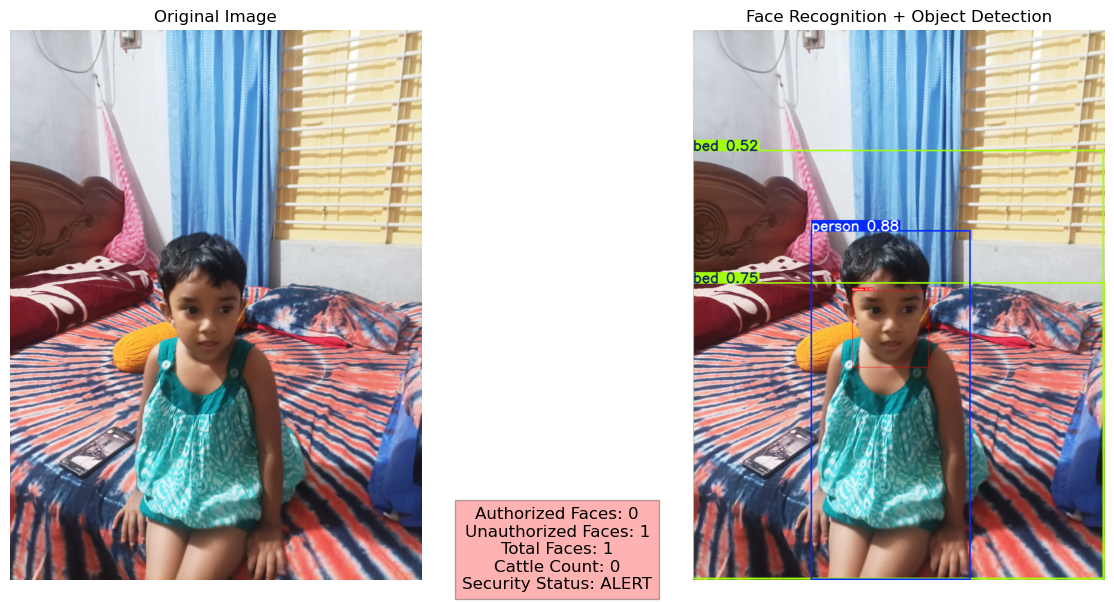

💾 Result saved: output/face_recognized_image2.jpg


In [12]:
# Cell 5: Process Images with Proper Face Recognition
def process_image_with_face_recognition(image_path):
    """Process image with enhanced face recognition"""
    print(f"🔍 Analyzing image with face recognition: {image_path}")
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return
    
    # Perform face recognition
    face_results = security_system.recognize_faces_in_frame(image)
    
    # Perform object detection
    detection_results = security_system.model(image, conf=security_system.config.confidence_threshold)
    
    # Create annotated image
    annotated_image = image.copy()
    
    # Draw face recognition results
    for face in face_results:
        top, right, bottom, left = face['location']
        name = face['name']
        confidence = face['confidence']
        is_authorized = face['is_authorized']
        
        # Choose color based on authorization
        if is_authorized:
            color = (0, 255, 0)  # Green for authorized
            label = f"{name} ({confidence:.2f})"
        else:
            color = (0, 0, 255)  # Red for unauthorized
            label = f"Unknown ({confidence:.2f})"
        
        # Draw face rectangle
        cv2.rectangle(annotated_image, (left, top), (right, bottom), color, 2)
        
        # Draw label background
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        cv2.rectangle(annotated_image, (left, top - label_size[1] - 10), 
                     (left + label_size[0], top), color, -1)
        
        # Draw label text
        cv2.putText(annotated_image, label, (left, top - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    # Draw object detection results
    if detection_results and len(detection_results) > 0:
        annotated_image = detection_results[0].plot(img=annotated_image)
    
    # Count results
    authorized_faces = len([f for f in face_results if f['is_authorized']])
    unauthorized_faces = len([f for f in face_results if not f['is_authorized']])
    
    # Count objects
    cattle_count = 0
    if detection_results and len(detection_results) > 0:
        for box in detection_results[0].boxes:
            cls = int(box.cls[0])
            class_name = security_system.model.names[cls]
            if class_name in ['cow', 'sheep']:
                cattle_count += 1
    
    # Display results
    processed_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.imshow(original_image_rgb)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(processed_image_rgb)
    ax2.set_title('Face Recognition + Object Detection')
    ax2.axis('off')
    
    # Detection summary
    detection_info = {
        'authorized_faces': authorized_faces,
        'unauthorized_faces': unauthorized_faces,
        'total_faces': len(face_results),
        'cattle_count': cattle_count,
        'security_status': 'SECURE' if unauthorized_faces == 0 else 'ALERT'
    }
    
    info_text = (
        f"Authorized Faces: {authorized_faces}\n"
        f"Unauthorized Faces: {unauthorized_faces}\n"
        f"Total Faces: {len(face_results)}\n"
        f"Cattle Count: {cattle_count}\n"
        f"Security Status: {detection_info['security_status']}"
    )
    
    plt.figtext(0.5, 0.01, info_text, ha="center", fontsize=12, 
                bbox={"facecolor": "green" if unauthorized_faces == 0 else "red", 
                      "alpha": 0.3, "pad": 5})
    
    plt.tight_layout()
    plt.show()
    
    # Save result
    output_path = f"output/face_recognized_{Path(image_path).name}"
    cv2.imwrite(output_path, annotated_image)
    print(f"💾 Result saved: {output_path}")
    
    # Trigger alert if unauthorized faces detected
    if unauthorized_faces > 0 and security_system.should_send_alert("unauthorized_face"):
        alert_details = {
            'unauthorized_faces': unauthorized_faces,
            'location': image_path,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        security_system.send_email_alert(annotated_image, "unauthorized_face", alert_details)
    
    return detection_info

# # Test face recognition with sample images
# print("🧪 Testing Face Recognition System...")
# sample_images = []
# for root, dirs, files in os.walk(config.family_members_dir):
#     for file in files:
#         if file.lower().endswith(('.jpg', '.jpeg', '.png')):
#             sample_images.append(os.path.join(root, file))

# if sample_images:
#     for img_path in sample_images[:2]:  # Test with first 2 images
#         results = process_image_with_face_recognition(img_path)
#         print(f"Face recognition results: {results}")
# else:
#     print("ℹ️  No sample face images found in family_members directory")
def test_custom_image_processing():
    """Test custom image processing functionality"""
    print("🖼️ CUSTOM IMAGE PROCESSING TEST")
    print("=" * 40)
    
    # Check if user wants to test with a custom image
    # custom_image_path = "elon_musk/image1.jpg"  # Replace with your custom image path
    custom_image_path = "rabita/image2.jpg"  # Replace with your custom image path
    
    if custom_image_path and os.path.exists(custom_image_path):
        results = process_image_with_face_recognition(custom_image_path)
        return results
    else:
        print("ℹ️  No custom image provided. You can use this function later.")
        return None

# Run custom image test
custom_image_results = test_custom_image_processing()

6. Enhanced Webcam with Real-time Face Recognition

In [ ]:
# Cell 6: Real-time Webcam with Face Recognition
def webcam_face_recognition(duration_seconds=20):
    """Run real-time face recognition on webcam"""
    print("🎥 Starting real-time face recognition...")
    print("Press 'q' to stop, 's' to save snapshot")
    
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Could not access webcam")
        return
    
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    start_time = datetime.now()
    frame_count = 0
    unauthorized_alerts = 0
    
    print(f"🔍 Loaded {len(security_system.known_face_names)} known faces:")
    for name in security_system.known_face_names:
        print(f"   👤 {name}")
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("❌ Failed to capture frame")
                break
            
            # Process every 4th frame for performance
            if frame_count % 4 == 0:
                # Perform face recognition
                face_results = security_system.recognize_faces_in_frame(frame)
                
                # Draw face recognition results
                for face in face_results:
                    top, right, bottom, left = face['location']
                    name = face['name']
                    confidence = face['confidence']
                    is_authorized = face['is_authorized']
                    
                    # Choose color and label
                    color = (0, 255, 0) if is_authorized else (0, 0, 255)
                    status = "Authorized" if is_authorized else "Unauthorized"
                    label = f"{name} ({confidence:.2f}) - {status}"
                    
                    # Draw rectangle and label
                    cv2.rectangle(frame, (left, top), (right, bottom), color, 2)
                    cv2.putText(frame, label, (left, top - 10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                    
                    # Trigger alert for unauthorized faces
                    if not is_authorized and security_system.should_send_alert(f"unauthorized_{frame_count}"):
                        unauthorized_alerts += 1
                        print(f"🚨 Unauthorized person detected! Confidence: {confidence:.2f}")
                
                # Display frame info
                authorized_count = len([f for f in face_results if f['is_authorized']])
                unauthorized_count = len([f for f in face_results if not f['is_authorized']])
                
                info_lines = [
                    f"Frame: {frame_count}",
                    f"Authorized: {authorized_count}",
                    f"Unauthorized: {unauthorized_count}",
                    f"Alerts: {unauthorized_alerts}",
                    "Press 'q' to quit"
                ]
                
                for i, line in enumerate(info_lines):
                    y_pos = 30 + i * 25
                    cv2.putText(frame, line, (10, y_pos), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            # Display frame
            cv2.imshow('Real-time Face Recognition - Press Q to quit', frame)
            
            # Handle key presses
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                snapshot_path = f"output/snapshot_face_{datetime.now().strftime('%Y%m%d_%H%M%S')}.jpg"
                cv2.imwrite(snapshot_path, frame)
                print(f"📸 Snapshot saved: {snapshot_path}")
            
            frame_count += 1
            
            # Check duration
            elapsed = (datetime.now() - start_time).total_seconds()
            if elapsed > duration_seconds:
                print(f"⏰ Face recognition completed after {duration_seconds} seconds")
                break
                
    except KeyboardInterrupt:
        print("🛑 Face recognition stopped by user")
    
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print(f"📊 Summary: {frame_count} frames, {unauthorized_alerts} unauthorized alerts")

# Test real-time face recognition
print("🎯 Testing Real-time Face Recognition...")
webcam_face_recognition(duration_seconds=15)

7. Face Recognition Testing Cell

In [ ]:
# Cell 7: Comprehensive Face Recognition Testing
def test_face_recognition_system():
    """Test the complete face recognition system"""
    print("🧪 COMPREHENSIVE FACE RECOGNITION TEST")
    print("=" * 50)
    
    # Display known faces information
    print(f"\n📊 KNOWN FACES DATABASE:")
    print(f"   Total known faces: {len(security_system.known_face_names)}")
    
    name_count = {}
    for name in security_system.known_face_names:
        name_count[name] = name_count.get(name, 0) + 1
    
    for name, count in name_count.items():
        print(f"   👤 {name}: {count} face encoding(s)")
    
    # Test with images from family_members directory
    print(f"\n🔍 TESTING WITH KNOWN FACES:")
    known_face_images = []
    for root, dirs, files in os.walk(config.family_members_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                known_face_images.append(os.path.join(root, file))
    
    if known_face_images:
        for img_path in known_face_images[:3]:  # Test with first 3 known faces
            print(f"\n   Testing: {Path(img_path).name}")
            image = cv2.imread(img_path)
            face_results = security_system.recognize_faces_in_frame(image)
            
            if face_results:
                for face in face_results:
                    expected_name = Path(img_path).parent.name
                    recognized_name = face['name']
                    confidence = face['confidence']
                    
                    if recognized_name == expected_name:
                        print(f"      ✅ Correctly recognized as {recognized_name} (confidence: {confidence:.2f})")
                    else:
                        print(f"      ❌ Misrecognized: expected {expected_name}, got {recognized_name}")
            else:
                print(f"      ⚠️  No faces detected in image")
    else:
        print("   ℹ️  No face images found in family_members directory")
    
    # Test face matching accuracy
    print(f"\n🎯 FACE MATCHING ACCURACY TEST:")
    if len(security_system.known_face_encodings) >= 2:
        # Test face distance between different people
        encoding1 = security_system.known_face_encodings[0]
        encoding2 = security_system.known_face_encodings[-1]
        
        distance = face_recognition.face_distance([encoding1], encoding2)[0]
        similarity = 1.0 - distance
        
        print(f"   Face similarity between {security_system.known_face_names[0]} and {security_system.known_face_names[-1]}:")
        print(f"   Distance: {distance:.4f}")
        print(f"   Similarity: {similarity:.4f}")
        print(f"   Match: {'YES' if similarity > config.face_threshold else 'NO'}")

# Run comprehensive test
test_face_recognition_system()

In [ ]:
# Cell 9: Process Custom Images with Detailed Face Recognition Analysis
def process_custom_image(image_path):
    """
    Process a custom image to detect and recognize faces with detailed analysis
    """
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return None
    
    print(f"🔍 Processing custom image: {image_path}")
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return None
    
    # Perform face recognition
    face_results = security_system.recognize_faces_in_frame(image)
    
    # Perform object detection
    detection_results = security_system.model(image, conf=security_system.config.confidence_threshold)
    
    # Create annotated image
    annotated_image = image.copy()
    
    # Detailed analysis
    analysis_results = {
        'image_path': image_path,
        'total_faces': len(face_results),
        'authorized_faces': [],
        'unauthorized_faces': [],
        'object_detections': [],
        'security_status': 'SECURE'
    }
    
    # Process face recognition results
    for i, face in enumerate(face_results):
        top, right, bottom, left = face['location']
        name = face['name']
        confidence = face['confidence']
        is_authorized = face['is_authorized']
        
        # Choose color based on authorization
        if is_authorized:
            color = (0, 255, 0)  # Green
            status = "AUTHORIZED"
            analysis_results['authorized_faces'].append({
                'name': name,
                'confidence': confidence,
                'location': (left, top, right, bottom)
            })
        else:
            color = (0, 0, 255)  # Red
            status = "UNAUTHORIZED"
            analysis_results['unauthorized_faces'].append({
                'name': name,
                'confidence': confidence,
                'location': (left, top, right, bottom)
            })
            analysis_results['security_status'] = 'ALERT'
        
        # Draw face rectangle
        cv2.rectangle(annotated_image, (left, top), (right, bottom), color, 3)
        
        # Draw info box
        label = f"{name} ({confidence:.2f}) - {status}"
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
        
        # Background for text
        cv2.rectangle(annotated_image, 
                     (left, top - label_size[1] - 15), 
                     (left + label_size[0], top), 
                     color, -1)
        
        # Text
        cv2.putText(annotated_image, label, (left, top - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Process object detections
    if detection_results and len(detection_results) > 0:
        annotated_image = detection_results[0].plot(img=annotated_image)
        
        # Count objects by type
        object_counts = {}
        for box in detection_results[0].boxes:
            cls = int(box.cls[0])
            class_name = security_system.model.names[cls]
            object_counts[class_name] = object_counts.get(class_name, 0) + 1
        
        analysis_results['object_detections'] = object_counts
    
    # Display comprehensive results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Original image
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Annotated image
    ax2.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    ax2.set_title('Security Analysis - Face Recognition + Object Detection', 
                 fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Detailed analysis text
    analysis_text = f"""
    📊 SECURITY ANALYSIS REPORT
    {'='*50}
    🖼️ Image: {Path(image_path).name}
    📅 Analysis Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    
    👤 FACE RECOGNITION RESULTS:
       • Total Faces Detected: {len(face_results)}
       • Authorized Persons: {len(analysis_results['authorized_faces'])}
       • Unauthorized Persons: {len(analysis_results['unauthorized_faces'])}
    
    🚨 SECURITY STATUS: {analysis_results['security_status']}
    """
    
    # Add authorized faces details
    if analysis_results['authorized_faces']:
        analysis_text += "\n    ✅ AUTHORIZED PERSONS:"
        for person in analysis_results['authorized_faces']:
            analysis_text += f"\n       • {person['name']} (confidence: {person['confidence']:.2f})"
    
    # Add unauthorized faces details
    if analysis_results['unauthorized_faces']:
        analysis_text += "\n    ❌ UNAUTHORIZED PERSONS:"
        for person in analysis_results['unauthorized_faces']:
            analysis_text += f"\n       • {person['name']} (confidence: {person['confidence']:.2f})"
    
    # Add object detection details
    if analysis_results['object_detections']:
        analysis_text += "\n\n    🎯 OBJECT DETECTIONS:"
        for obj, count in analysis_results['object_detections'].items():
            analysis_text += f"\n       • {obj}: {count}"
    
    # Display analysis text
    plt.figtext(0.5, 0.01, analysis_text, ha="center", fontsize=11, 
                bbox={"facecolor": "lightgreen" if analysis_results['security_status'] == 'SECURE' else "lightcoral", 
                      "alpha": 0.7, "pad": 10},
                family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # Save result
    output_path = f"output/custom_analysis_{Path(image_path).stem}.jpg"
    cv2.imwrite(output_path, annotated_image)
    print(f"💾 Analysis saved: {output_path}")
    
    # Trigger alert if unauthorized faces detected
    if analysis_results['unauthorized_faces'] and security_system.should_send_alert("custom_image_alert"):
        alert_details = {
            'unauthorized_count': len(analysis_results['unauthorized_faces']),
            'authorized_count': len(analysis_results['authorized_faces']),
            'image_path': image_path,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        security_system.send_email_alert(annotated_image, "unauthorized_in_custom_image", alert_details)
        print(f"🚨 Security alert triggered for {len(analysis_results['unauthorized_faces'])} unauthorized persons!")
    
    return analysis_results

# Test with a custom image
def test_custom_image_processing():
    """Test custom image processing functionality"""
    print("🖼️ CUSTOM IMAGE PROCESSING TEST")
    print("=" * 40)
    
    # Check if user wants to test with a custom image
    custom_image_path = input("Enter path to custom image (or press Enter to skip): ").strip()
    
    if custom_image_path and os.path.exists(custom_image_path):
        results = process_custom_image(custom_image_path)
        return results
    else:
        print("ℹ️  No custom image provided. You can use this function later.")
        return None

# Run custom image test
custom_image_results = test_custom_image_processing()